In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [12]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / (np.sum(np.abs(y_true)) + 1e-6)

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / (denominator + 1e-6))

In [2]:
df = pd.read_csv('DF_FINAL.csv')
df['Week_End_Date'] = pd.to_datetime(df['Week_End_Date'])
df

,Territory_code,Plant_code,Brand_code,Package,Week_End_Date,Sum of Plan,fact,row_id
0,A,a,AC,TP 0.2,2023-01-06,1.000000,0.010000,A_a_AC_TP 0.2
1,A,a,AC,TP 0.2,2023-01-13,1.000000,4.010000,A_a_AC_TP 0.2
2,A,a,AC,TP 0.2,2023-01-20,61.000000,6.010000,A_a_AC_TP 0.2
3,A,a,AC,TP 0.2,2023-01-27,0.000000,8.010000,A_a_AC_TP 0.2
4,A,a,AC,TP 0.2,2023-02-03,18.879000,9.520000,A_a_AC_TP 0.2
...,...,...,...,...,...,...,...,...
58305,I,an,AD,PET 1.0,2024-11-29,54.766687,78.192999,I_an_AD_PET 1.0
58306,I,an,AD,PET 1.0,2024-12-06,65.133425,171.193998,I_an_AD_PET 1.0
58307,I,an,AD,PET 1.0,2024-12-13,59.458602,46.503001,I_an_AD_PET 1.0
58308,I,an,AD,PET 1.0,2024-12-20,77.697035,8.463000,I_an_AD_PET 1.0


In [3]:
# Параметры
TARGET_ROW_ID = 'A_a_AD_PET 1.0'
EPSILON = 1e-5  # Для избежания деления на 0

In [4]:
# 1. Фильтрация по ряду и сортировка
df_single = df[df['row_id'] == TARGET_ROW_ID].copy()
df_single.sort_values('Week_End_Date', inplace=True)

# 2. Временные признаки
df_single['week_number'] = df_single['Week_End_Date'].dt.isocalendar().week
df_single['month'] = df_single['Week_End_Date'].dt.month
df_single['quarter'] = df_single['Week_End_Date'].dt.quarter

# 3. Лаги
for lag in [1, 2, 3, 4, 5, 7]:
    df_single[f'lag_{lag}'] = df_single['fact'].shift(lag)

# 4. Скользящие средние и стандартные отклонения
for window in [3, 5, 7]:
    df_single[f'rolling_mean_{window}'] = df_single['fact'].rolling(window).mean()
    df_single[f'rolling_std_{window}'] = df_single['fact'].rolling(window).std()

# 5. Трендовые признаки
df_single['trend_3'] = df_single['fact'] - df_single['fact'].shift(3)
df_single['momentum'] = (df_single['fact'] - df_single['fact'].shift(1)) / \
                        (df_single['fact'].shift(2) - df_single['fact'].shift(3) + EPSILON)

# 6. Удаление строк с NaN (первые недели)
df_single.dropna(inplace=True)
df_single

,Territory_code,Plant_code,Brand_code,Package,Week_End_Date,Sum of Plan,fact,row_id,week_number,month,...,lag_5,lag_7,rolling_mean_3,rolling_std_3,rolling_mean_5,rolling_std_5,rolling_mean_7,rolling_std_7,trend_3,momentum
215,A,a,AD,PET 1.0,2023-02-24,465.137011,6699.518123,A_a_AD_PET 1.0,8,2,...,557.010000,188.010000,3187.736037,3055.346960,2285.074821,2521.906721,1749.770587,2254.515116,6342.362127,6.362085
216,A,a,AD,PET 1.0,2023-03-03,2694.585936,42.276000,A_a_AD_PET 1.0,9,3,...,1505.010000,266.010000,2822.119695,3461.674156,1992.528021,2712.645448,1717.808587,2280.492335,-1096.849024,-11.371349
217,A,a,AD,PET 1.0,2023-03-10,87.696000,14.802000,A_a_AD_PET 1.0,10,3,...,357.155996,557.010000,2252.198708,3851.516090,1924.057222,2768.000118,1640.350301,2335.046442,-1709.762962,-0.005522
218,A,a,AD,PET 1.0,2023-03-17,49.050002,57.068001,A_a_AD_PET 1.0,11,3,...,1139.125025,1505.010000,38.048667,21.447762,1707.645817,2884.556262,1433.501444,2411.901463,-6642.450122,-0.006349
219,A,a,AD,PET 1.0,2023-03-24,50.357000,141.601997,A_a_AD_PET 1.0,12,3,...,1724.564962,357.155996,71.157333,64.563471,1391.053224,2967.899592,1402.708015,2429.247449,99.325997,-3.076874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,A,a,AD,PET 1.0,2024-11-29,89.252734,103.561001,A_a_AD_PET 1.0,48,11,...,78.200999,232.475996,85.950667,15.577066,78.202200,18.117797,72.164000,21.772425,50.719000,1.076872
308,A,a,AD,PET 1.0,2024-12-06,0.000000,0.010000,A_a_AD_PET 1.0,49,12,...,80.317001,35.936000,59.182000,53.336920,62.140800,39.155853,67.031714,33.049408,-80.306001,16.330409
309,A,a,AD,PET 1.0,2024-12-13,112.752272,169.080002,A_a_AD_PET 1.0,50,12,...,52.842000,78.200999,90.883667,85.244956,85.388400,60.786499,80.014429,51.092765,95.105003,5.714525
310,A,a,AD,PET 1.0,2024-12-20,95.839429,164.851998,A_a_AD_PET 1.0,51,12,...,80.316001,80.317001,111.314000,96.415270,102.295600,70.070431,92.090857,60.331397,61.290998,0.040830


In [5]:
INPUT_SEQ_LEN = 12  # длина входа
FORECAST_HORIZON = 4  # длина прогноза
EPSILON = 1e-6

In [6]:
drop_cols = ['Week_End_Date', 'row_id', 'fact',
             'Territory_code', 'Plant_code', 'Brand_code', 'Package']
feature_cols = [col for col in df_single.columns if col not in drop_cols]

# Масштабируем все фичи
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_single[feature_cols])

# Нормализация таргета (если нужно)
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(df_single[['fact']])

# Формируем выборку для LSTM
X, y = [], []
for i in range(len(df_single) - INPUT_SEQ_LEN - FORECAST_HORIZON + 1):
    X_window = X_scaled[i : i + INPUT_SEQ_LEN]
    y_window = y_scaled[i + INPUT_SEQ_LEN : i + INPUT_SEQ_LEN + FORECAST_HORIZON].flatten()
    X.append(X_window)
    y.append(y_window)

# Конвертируем в numpy
X = np.array(X)  # shape: (samples, time_steps, features)
y = np.array(y)  # shape: (samples, forecast_horizon)

X.shape, y.shape

((82, 12, 18), (82, 4))

In [7]:
train_size = int(0.90 * len(X))
val_size = int(0.05 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size : train_size + val_size]
y_val = y[train_size : train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

In [38]:
len(X_test)

5

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
# Архитектура модели
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='relu')  # выход с ReLU, чтобы не было отрицательных значений
])

model.compile(optimizer='adam', loss='mae')

# Callback для ранней остановки
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0109 - val_loss: 0.0115
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0112 - val_loss: 0.0117
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0112 - val_loss: 0.0117
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0109 - val_loss: 0.0117
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0108 - val_loss: 0.0117
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0110 - val_loss: 0.0117
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0109 - val_loss: 0.0117
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0109 - val_loss: 0.0117
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0111 - val_lo

In [30]:
# 1. Прогноз
y_pred_scaled = model.predict(X_test)

# 2. Обратное масштабирование
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test)

# Проверим форму
y_pred.shape, y_true.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


((5, 4), (5, 4))

In [31]:
# Плоские массивы
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

print(f"MAE:  {mae(y_true_flat, y_pred_flat):.4f}")
print(f"WAPE: {wape(y_true_flat, y_pred_flat):.4f}")
print(f"SMAPE:{smape(y_true_flat, y_pred_flat):.4f}")

MAE:  91.7334
WAPE: 1.0677
SMAPE:1.4256


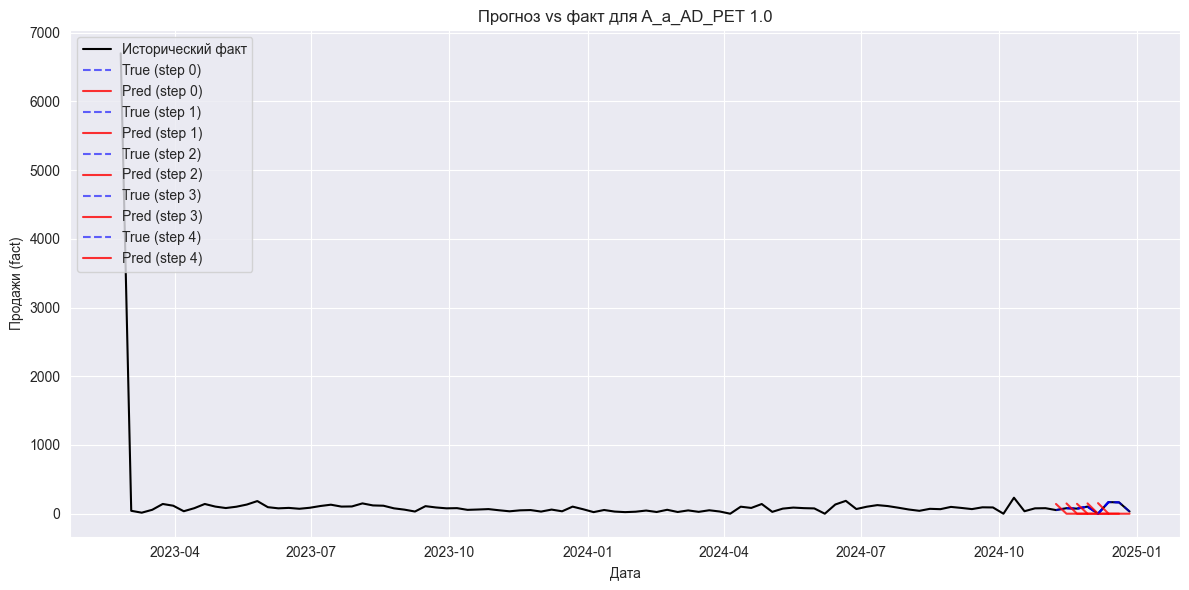

In [36]:
# 1. Весь временной ряд
dates = df_single['Week_End_Date'].reset_index(drop=True)

# 2. Последние N примеров (N = len(y_test)), каждый с forecast_horizon точек
horizon = y_pred.shape[1]
start_idx = len(dates) - (len(y_pred) + horizon - 1)

# 3. Исторический факт
plt.figure(figsize=(12, 6))
plt.plot(dates, df_single['fact'], label='Исторический факт', color='black')

# 4. Отрисовка предсказания и истинного значения
for i in range(len(y_pred)):
    forecast_dates = dates[start_idx + i : start_idx + i + horizon]

    # True
    plt.plot(forecast_dates, y_true[i], label=f'True (step {i})', color='blue', linestyle='--', alpha=0.6)

    # Predicted
    plt.plot(forecast_dates, y_pred[i], label=f'Pred (step {i})', color='red', alpha=0.8)

# Оформление
plt.title(f'Прогноз vs факт для {TARGET_ROW_ID}')
plt.xlabel('Дата')
plt.ylabel('Продажи (fact)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

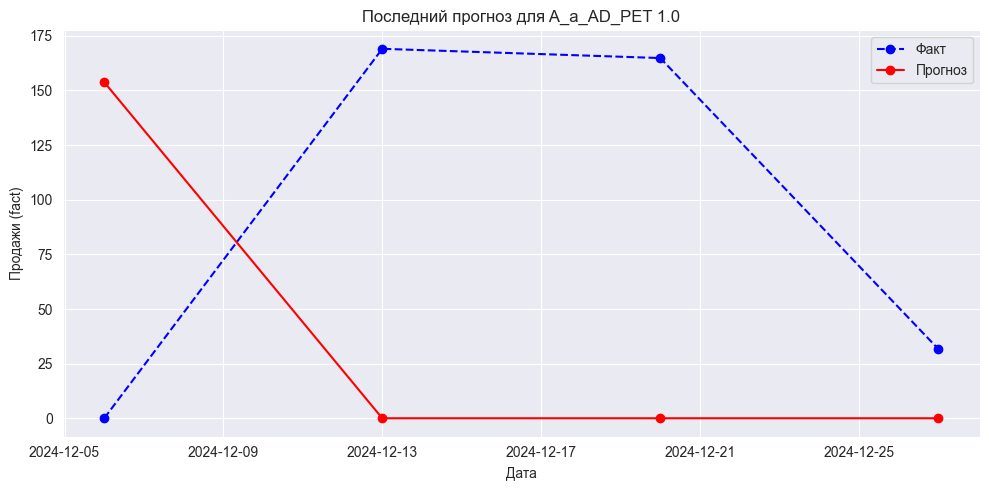

In [37]:
# Даты последних 4 недель
forecast_dates = df_single['Week_End_Date'].iloc[-4:]

# Построение графика
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(forecast_dates, y_true[-1], label='Факт', marker='o', linestyle='--', color='blue')
plt.plot(forecast_dates, y_pred[-1], label='Прогноз', marker='o', linestyle='-', color='red')

plt.title(f'Последний прогноз для {TARGET_ROW_ID}')
plt.xlabel('Дата')
plt.ylabel('Продажи (fact)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ПОПЫТКА 2

In [40]:
HOLDOUT_WEEKS = 4
df_holdout = df_single.iloc[-HOLDOUT_WEEKS:].copy()
df_trainval = df_single.iloc[:-HOLDOUT_WEEKS].copy()

In [113]:
INPUT_SEQ_LEN = 18
FORECAST_HORIZON = 4

# Убираем ненужные колонки
drop_cols = ['Week_End_Date', 'row_id', 'fact',
             'Territory_code', 'Plant_code', 'Brand_code', 'Package']
feature_cols = [col for col in df_trainval.columns if col not in drop_cols]

# Масштабирование признаков
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(df_trainval[feature_cols])

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(df_trainval[['fact']])

# Формируем X и y
X, y = [], []
for i in range(len(df_trainval) - INPUT_SEQ_LEN - FORECAST_HORIZON + 1):
    X_window = X_scaled[i : i + INPUT_SEQ_LEN]
    y_window = y_scaled[i + INPUT_SEQ_LEN : i + INPUT_SEQ_LEN + FORECAST_HORIZON].flatten()
    X.append(X_window)
    y.append(y_window)

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((72, 18, 18), (72, 4))

In [114]:
train_size = int(0.90 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

In [167]:
from tensorflow.keras.regularizers import l2
import tensorflow as tf

In [219]:
model = Sequential([
    LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='tanh'),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='linear')
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [220]:
# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0023 - val_loss: 7.8750e-04
Epoch 2/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.9888e-04 - val_loss: 3.5159e-04
Epoch 3/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.6443e-04 - val_loss: 1.2285e-04
Epoch 4/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0586e-04 - val_loss: 2.8796e-04
Epoch 5/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2588e-04 - val_loss: 1.3178e-04
Epoch 6/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.8084e-05 - val_loss: 1.0765e-04
Epoch 7/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.4418e-05 - val_loss: 1.4517e-04
Epoch 8/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.6063e-05 - val_loss: 9.1148e-05
Epoch 9/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.7680e-05 - val_loss: 1.2612e-04
Epoch 10/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.2972e-05 - val_loss: 9.7032e-05
Epoch 11/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3384e-05 - val_loss: 

In [221]:
# Последние 18 недель (до hold-out) для прогноза
X_holdout_raw = df_single[feature_cols].iloc[-(INPUT_SEQ_LEN + HOLDOUT_WEEKS):-HOLDOUT_WEEKS]
X_holdout_scaled = scaler_x.transform(X_holdout_raw)
X_holdout = X_holdout_scaled.reshape(1, INPUT_SEQ_LEN, -1)

# Прогноз
y_pred_scaled = model.predict(X_holdout)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_pred = np.clip(y_pred, 0, None) # добавлено

# Истинные продажи hold-out
y_true = df_holdout['fact'].values.reshape(1, -1)

# Проверим форму
y_pred.shape, y_true.shape


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


((1, 4), (1, 4))

In [222]:
# Плоские массивы
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

print(f"MAE:   {mae(y_true_flat, y_pred_flat):.4f}")
print(f"WAPE:  {wape(y_true_flat, y_pred_flat):.4f}")
print(f"SMAPE: {smape(y_true_flat, y_pred_flat):.4f}")

MAE:   61.2632
WAPE:  0.6702
SMAPE: 0.9724


In [223]:
y_true_flat

array([1.00000000e-02, 1.69080002e+02, 1.64851998e+02, 3.17099998e+01])

In [224]:
y_pred_flat

array([55.322884, 82.237564, 89.70285 , 59.458157], dtype=float32)

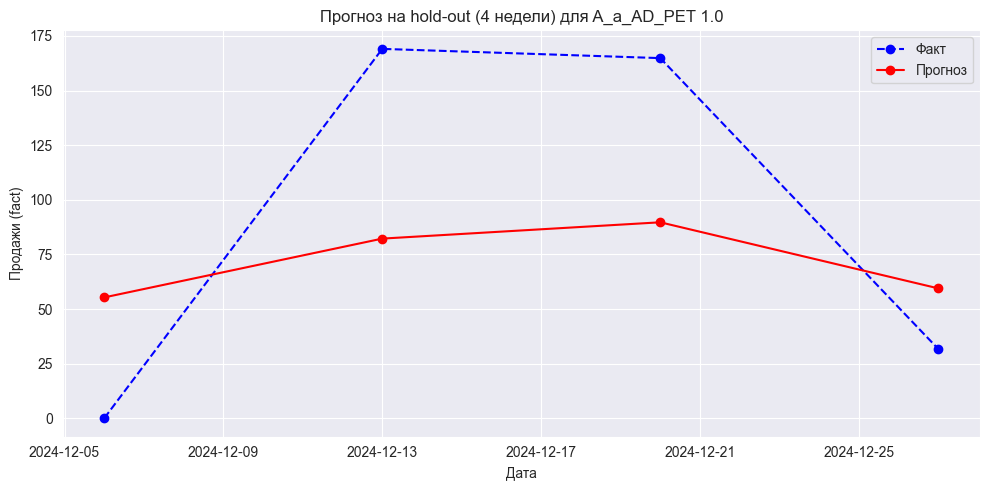

In [225]:
# Даты hold-out
forecast_dates = df_holdout['Week_End_Date'].values

plt.figure(figsize=(10, 5))
plt.plot(forecast_dates, y_true.flatten(), label='Факт', marker='o', linestyle='--', color='blue')
plt.plot(forecast_dates, y_pred.flatten(), label='Прогноз', marker='o', linestyle='-', color='red')

plt.title(f'Прогноз на hold-out (4 недели) для {TARGET_ROW_ID}')
plt.xlabel('Дата')
plt.ylabel('Продажи (fact)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ДЛЯ ВСЕГО ДАТАСЕТА

In [245]:
from sklearn.metrics import mean_absolute_error
import os

In [246]:
def train_and_evaluate_model(df, row_id):

    # 1. Фильтрация и сортировка
    df_single = df[df['row_id'] == row_id].copy()
    df_single.sort_values('Week_End_Date', inplace=True)

    # 2. Признаки (как ранее подготовленные df_single)
    df_single['week_number'] = df_single['Week_End_Date'].dt.isocalendar().week
    df_single['month'] = df_single['Week_End_Date'].dt.month
    df_single['quarter'] = df_single['Week_End_Date'].dt.quarter

    for lag in [1, 2, 3, 4, 5, 7]:
        df_single[f'lag_{lag}'] = df_single['fact'].shift(lag)

    for window in [3, 5, 7]:
        df_single[f'rolling_mean_{window}'] = df_single['fact'].rolling(window).mean()
        df_single[f'rolling_std_{window}'] = df_single['fact'].rolling(window).std()

    EPSILON = 1e-5
    df_single['trend_3'] = df_single['fact'] - df_single['fact'].shift(3)
    df_single['momentum'] = (df_single['fact'] - df_single['fact'].shift(1)) / \
                            (df_single['fact'].shift(2) - df_single['fact'].shift(3) + EPSILON)

    df_single.dropna(inplace=True)

    # 3. Holdout-отделение
    HOLDOUT_WEEKS = 4
    df_holdout = df_single.iloc[-HOLDOUT_WEEKS:].copy()
    df_trainval = df_single.iloc[:-HOLDOUT_WEEKS].copy()

    # 4. Подготовка X и y
    INPUT_SEQ_LEN = 18
    FORECAST_HORIZON = 4

    drop_cols = ['Week_End_Date', 'row_id', 'fact',
                 'Territory_code', 'Plant_code', 'Brand_code', 'Package']
    feature_cols = [col for col in df_trainval.columns if col not in drop_cols]

    scaler_x = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(df_trainval[feature_cols])

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(df_trainval[['fact']])

    X, y = [], []
    for i in range(len(df_trainval) - INPUT_SEQ_LEN - FORECAST_HORIZON + 1):
        X_window = X_scaled[i: i + INPUT_SEQ_LEN]
        y_window = y_scaled[i + INPUT_SEQ_LEN: i + INPUT_SEQ_LEN + FORECAST_HORIZON].flatten()
        X.append(X_window)
        y.append(y_window)

    X = np.array(X)
    y = np.array(y)
    
    # Проверка на корректную размерность и объём данных
    if len(X) == 0 or len(y) == 0 or X.ndim != 3 or y.ndim != 2:
        return None

    # 5. Трейн/валид
    split_idx = int(len(X) * 0.9)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    # 6. Модель
    model = Sequential([
        LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(64, activation='tanh'),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # 7. Обучение
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=400, batch_size=16, callbacks=[early_stop], verbose=0)

    # 8. Holdout X
    # Последние 18 недель (до hold-out) для прогноза
    X_holdout_raw = df_single[feature_cols].iloc[-(INPUT_SEQ_LEN + HOLDOUT_WEEKS):-HOLDOUT_WEEKS]
    X_holdout_scaled = scaler_x.transform(X_holdout_raw)
    X_holdout = X_holdout_scaled.reshape(1, INPUT_SEQ_LEN, -1)

    # Прогноз
    y_pred_scaled = model.predict(X_holdout)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_pred = np.clip(y_pred, 0, None) # добавлено

    # Истинные продажи hold-out
    y_true = df_holdout['fact'].values.reshape(1, -1)
    
    # Плоские массивы
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # 9. Метрики
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    wape = np.sum(np.abs(y_true_flat - y_pred_flat)) / (np.sum(np.abs(y_true_flat)) + EPSILON)
    smape = 100 * np.mean(2 * np.abs(y_true_flat - y_pred_flat) / (np.abs(y_true_flat) + np.abs(y_pred_flat) + EPSILON))
    
    # 10. Сохранение модели
    model_dir = "saved_models_LSTM"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"{row_id}.h5")
    model.save(model_path)

    return {
        'row_id': row_id,
        'MAE': mae,
        'WAPE': wape,
        'SMAPE': smape
    }

In [247]:
from joblib import Parallel, delayed

In [248]:
# Список всех уникальных рядов
row_ids = df['row_id'].unique()

In [249]:
# Параллельный запуск
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_and_evaluate_model)(df, row_id) for row_id in row_ids
)

# Убираем None (если какие-то ряды не прошли)
results_cleaned = [res for res in results if res is not None]

# Финальный DataFrame
results_df = pd.DataFrame(results_cleaned)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  2.7min
F:\Games\JetBrains\Projects\VKR\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 149 tasks  

In [250]:
results_df

,row_id,MAE,WAPE,SMAPE
0,A_a_AC_TP 0.2,1.844408,0.964647,95.463145
1,A_a_AC_TP 1.0,45.105350,0.871020,112.781691
2,A_a_AD_PET 1.0,63.886637,0.698879,108.830192
3,A_b_AA_PET 0.5,72.322472,0.800390,94.513769
4,A_b_AA_PET 1.0,39.234282,1.279907,122.398613
...,...,...,...,...
596,I_am_AH_PET 1.0,188.471988,0.699496,89.644456
597,I_am_AJ_PET 1.0,44.134159,0.500207,79.023741
598,I_an_AC_PET 0.3,9.126397,1.027053,180.628049
599,I_an_AC_TP 2.0,265.728914,0.989997,171.567513


In [253]:
results_df['WAPE_true'] = results_df['WAPE'] * 100
results_df['WAPE_true'] = results_df['WAPE_true'].clip(upper=300)

In [254]:
results_df.describe()

,MAE,WAPE,SMAPE,WAPE_true
count,601.000000,601.000000,601.000000,601.000000
mean,181.993755,2.601374,107.415438,117.939569
std,334.414573,9.850394,48.905964,79.165318
min,0.434122,0.107215,10.243892,10.721468
25%,11.228397,0.632496,68.326057,63.249582
50%,50.414949,0.897657,99.324552,89.765687
75%,185.350332,1.455371,152.028784,145.537052
max,3129.427312,151.479509,199.999966,300.000000


In [255]:
selected_ids = [
    'E_u_AD_PET 0.5',
    'I_am_AE_PET 0.45',
    'A_c_AJ_PET 0.5',
    'D_o_AC_TP 0.2',
    'I_am_AA_PET 0.5'
]

filtered_results = results_df[results_df['row_id'].isin(selected_ids)]
filtered_results

,row_id,MAE,WAPE,SMAPE,WAPE_true
27,A_c_AJ_PET 0.5,72.270323,1.068463,188.621616,106.846321
247,D_o_AC_TP 0.2,58.191371,0.861667,77.493401,86.166671
346,E_u_AD_PET 0.5,58.737711,0.766696,59.518186,76.669572
581,I_am_AA_PET 0.5,9.783558,1.233079,116.637006,123.307869
591,I_am_AE_PET 0.45,18.405530,0.744079,110.473735,74.407860


In [264]:
from tensorflow.keras.models import load_model
from tensorflow import keras

In [265]:
def plot_saved_model_forecast(df, row_id):
    # 1. Подготовка данных
    df_single = df[df['row_id'] == row_id].copy()
    df_single.sort_values('Week_End_Date', inplace=True)

    INPUT_SEQ_LEN = 18
    FORECAST_HORIZON = 4

    df_single['week_number'] = df_single['Week_End_Date'].dt.isocalendar().week
    df_single['month'] = df_single['Week_End_Date'].dt.month
    df_single['quarter'] = df_single['Week_End_Date'].dt.quarter

    for lag in [1, 2, 3, 4, 5, 7]:
        df_single[f'lag_{lag}'] = df_single['fact'].shift(lag)

    for window in [3, 5, 7]:
        df_single[f'rolling_mean_{window}'] = df_single['fact'].rolling(window).mean()
        df_single[f'rolling_std_{window}'] = df_single['fact'].rolling(window).std()

    EPSILON = 1e-5
    df_single['trend_3'] = df_single['fact'] - df_single['fact'].shift(3)
    df_single['momentum'] = (df_single['fact'] - df_single['fact'].shift(1)) / \
                            (df_single['fact'].shift(2) - df_single['fact'].shift(3) + EPSILON)

    df_single.dropna(inplace=True)

    # Holdout
    df_holdout = df_single.iloc[-FORECAST_HORIZON:]
    df_features = df_single.iloc[-(INPUT_SEQ_LEN + FORECAST_HORIZON):-FORECAST_HORIZON]

    drop_cols = ['Week_End_Date', 'row_id', 'fact',
                 'Territory_code', 'Plant_code', 'Brand_code', 'Package']
    feature_cols = [col for col in df_single.columns if col not in drop_cols]

    # 2. Масштабирование
    from sklearn.preprocessing import MinMaxScaler
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_x.fit_transform(df_features[feature_cols])
    y_scaled = scaler_y.fit_transform(df_single[['fact']])

    X_input = X_scaled.reshape(1, INPUT_SEQ_LEN, -1)

    # 3. Загрузка модели
    model_path = f"saved_models_LSTM/{row_id}.h5"
    if not os.path.exists(model_path):
        print(f"Модель для {row_id} не найдена.")
        return

    model = keras.models.load_model(model_path, compile=False)

    # 4. Прогноз
    y_pred_scaled = model.predict(X_input)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_pred = np.clip(y_pred, 0, None)

    # 5. Истинные значения
    y_true = df_holdout['fact'].values
    dates = df_holdout['Week_End_Date'].values

    # 6. График
    plt.figure(figsize=(8, 4))
    plt.plot(dates, y_true, marker='o', label='Факт')
    plt.plot(dates, y_pred, marker='o', label='Прогноз')
    plt.title(f'Прогноз vs Факт — {row_id}')
    plt.xlabel('Дата')
    plt.ylabel('Продажи')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Строим график для: E_u_AD_PET 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


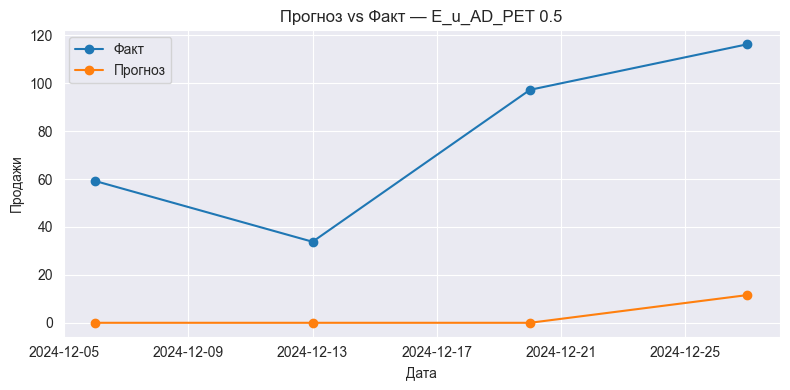

Строим график для: I_am_AE_PET 0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


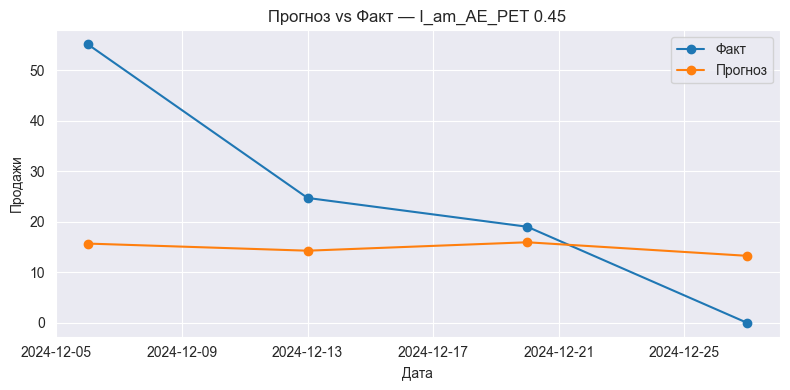

Строим график для: A_c_AJ_PET 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


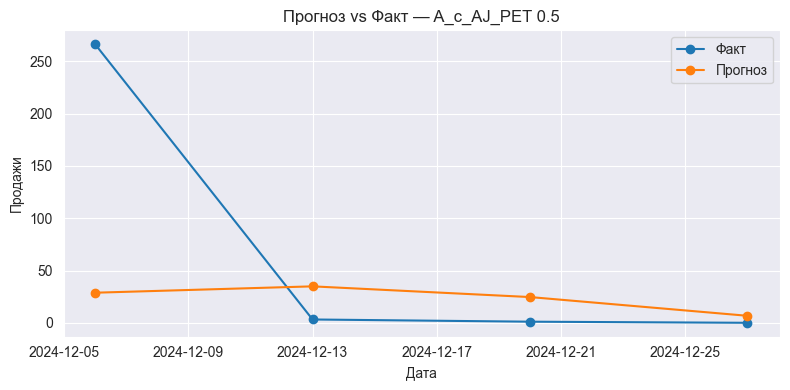

Строим график для: D_o_AC_TP 0.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


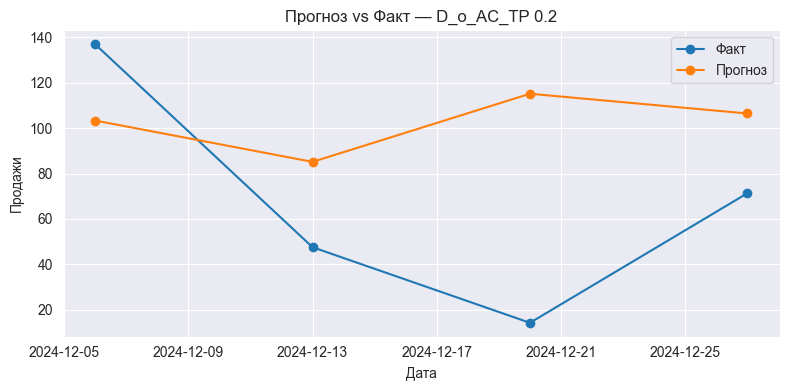

Строим график для: I_am_AA_PET 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


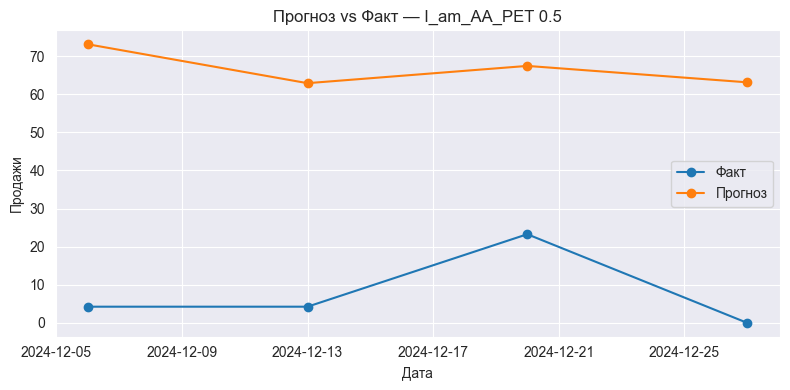

In [266]:
for row_id in selected_ids:
    print(f"Строим график для: {row_id}")
    plot_saved_model_forecast(df, row_id)

In [267]:
check_df = pd.read_csv('DF_FINAL.csv')
check_df['Week_End_Date'] = pd.to_datetime(check_df['Week_End_Date'])
check_df

,Territory_code,Plant_code,Brand_code,Package,Week_End_Date,Sum of Plan,fact,row_id
0,A,a,AC,TP 0.2,2023-01-06,1.000000,0.010000,A_a_AC_TP 0.2
1,A,a,AC,TP 0.2,2023-01-13,1.000000,4.010000,A_a_AC_TP 0.2
2,A,a,AC,TP 0.2,2023-01-20,61.000000,6.010000,A_a_AC_TP 0.2
3,A,a,AC,TP 0.2,2023-01-27,0.000000,8.010000,A_a_AC_TP 0.2
4,A,a,AC,TP 0.2,2023-02-03,18.879000,9.520000,A_a_AC_TP 0.2
...,...,...,...,...,...,...,...,...
58305,I,an,AD,PET 1.0,2024-11-29,54.766687,78.192999,I_an_AD_PET 1.0
58306,I,an,AD,PET 1.0,2024-12-06,65.133425,171.193998,I_an_AD_PET 1.0
58307,I,an,AD,PET 1.0,2024-12-13,59.458602,46.503001,I_an_AD_PET 1.0
58308,I,an,AD,PET 1.0,2024-12-20,77.697035,8.463000,I_an_AD_PET 1.0


In [269]:
check_results = []

for row_id, group in check_df.groupby('row_id'):
    # Сортировка по дате и выбор последних 4 недель
    recent_data = group.sort_values('Week_End_Date').tail(4)
    
    y_true_check = recent_data['fact'].values
    y_pred_check = recent_data['Sum of Plan'].values
    
    check_results.append({
        'row_id': row_id,
        'MAE': mae(y_true_check, y_pred_check),
        'WAPE': wape(y_true_check, y_pred_check),
        'SMAPE': smape(y_true_check, y_pred_check)
    })

# Финальный DataFrame с метриками
metrics_df = pd.DataFrame(check_results)

In [270]:
metrics_df

,row_id,MAE,WAPE,SMAPE
0,A_a_AC_TP 0.2,6.218855,3.252539,1.466222
1,A_a_AC_TP 1.0,28.890431,0.557897,0.947194
2,A_a_AD_PET 1.0,42.707130,0.467189,0.941006
3,A_b_AA_PET 0.5,118.836306,1.315157,0.915250
4,A_b_AA_PET 1.0,151.114435,4.929681,1.350429
...,...,...,...,...
597,I_am_AH_PET 1.0,154.291480,0.572638,0.715908
598,I_am_AJ_PET 1.0,36.240307,0.410740,0.658413
599,I_an_AC_PET 0.3,8.807401,0.991155,1.648967
600,I_an_AC_TP 2.0,264.606267,0.985815,1.611236


In [271]:
metrics_df['WAPE_true'] = metrics_df['WAPE'] * 100
metrics_df['WAPE_true'] = metrics_df['WAPE_true'].clip(upper=300)
metrics_df

,row_id,MAE,WAPE,SMAPE,WAPE_true
0,A_a_AC_TP 0.2,6.218855,3.252539,1.466222,300.000000
1,A_a_AC_TP 1.0,28.890431,0.557897,0.947194,55.789726
2,A_a_AD_PET 1.0,42.707130,0.467189,0.941006,46.718881
3,A_b_AA_PET 0.5,118.836306,1.315157,0.915250,131.515736
4,A_b_AA_PET 1.0,151.114435,4.929681,1.350429,300.000000
...,...,...,...,...,...
597,I_am_AH_PET 1.0,154.291480,0.572638,0.715908,57.263816
598,I_am_AJ_PET 1.0,36.240307,0.410740,0.658413,41.073998
599,I_an_AC_PET 0.3,8.807401,0.991155,1.648967,99.115467
600,I_an_AC_TP 2.0,264.606267,0.985815,1.611236,98.581488


In [272]:
metrics_df.describe()

,MAE,WAPE,SMAPE,WAPE_true
count,602.000000,602.000000,602.000000,602.000000
mean,150.736965,2.215323,1.032832,112.405664
std,285.805972,8.962941,0.513004,83.442360
min,0.155362,0.023302,0.143381,2.330221
25%,10.912521,0.542207,0.600593,54.220707
50%,44.465263,0.854278,0.963461,85.427813
75%,149.519928,1.338144,1.467412,133.814370
max,3399.195120,161.599701,1.999847,300.000000


In [273]:
filtered_check = metrics_df[metrics_df['row_id'].isin(selected_ids)]
filtered_check

,row_id,MAE,WAPE,SMAPE,WAPE_true
27,A_c_AJ_PET 0.5,67.412117,0.996638,1.382258,99.663828
247,D_o_AC_TP 0.2,51.983654,0.769746,0.824195,76.974618
346,E_u_AD_PET 0.5,53.566503,0.699197,0.599498,69.919664
582,I_am_AA_PET 0.5,27.165430,3.423818,1.450927,300.000000
592,I_am_AE_PET 0.45,14.910356,0.602780,0.895116,60.277959
